In [1]:
import os 
from dotenv import load_dotenv

load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm= ChatGroq(model="llama-3.1-8b-instant")

result = llm.invoke("Hello")
result

AIMessage(content='Hello.  Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 36, 'total_tokens': 55, 'completion_time': 0.020754755, 'prompt_time': 0.00157095, 'queue_time': 0.04969171, 'total_time': 0.022325705}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--522a768d-6c90-4e9b-84d2-ab06e45fe860-0', usage_metadata={'input_tokens': 36, 'output_tokens': 19, 'total_tokens': 55})

In [2]:
### Custom tools
def multiply(a:int, b:int) -> int:
    """
    Multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Add a and b
    Args:
        a: first int
        b: second int
    """
    return a + b

def division(a: int, b: int) -> float:
    """
    Multiply a and b
    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [multiply, add, division]

llm_with_tools = llm.bind_tools(tools=tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000027EE7951AC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027EE7B96EA0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'division', 'description': 'Multiply a and b\nArgs:\n    a: first int\n    b: second int', 'parameters': {'properties': {'a': {'t

C:\Users\rajpu\AppData\Local\Temp\ipykernel_50404\2068712558.py:2: DeprecationWarning: module 'sre_parse' is deprecated
  from sre_parse import State


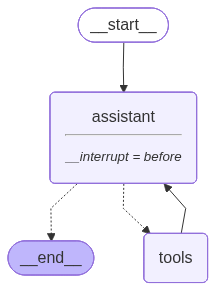

In [3]:
### Workflow with langgraph
from sre_parse import State
from IPython.display import display, Image

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

### System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic in a set of inputs."
)


## Nodes
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}


## Graph
builder = StateGraph(MessagesState)

## Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

## define the edges 
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

## Human in the loop
graph = builder.compile(
    interrupt_before=["assistant"],
    checkpointer=memory
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
thread = {"configurable":{"thread_id":"a123"}}
initial_input = {"messages":HumanMessage(content="multiply 2 and 3")}

In [5]:
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state.next

('assistant',)

In [7]:
state

StateSnapshot(values={'messages': [HumanMessage(content='multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7568a1bf-bd05-4ac2-abe1-e8fb2a5a3af5')]}, next=('assistant',), config={'configurable': {'thread_id': 'a123', 'checkpoint_ns': '', 'checkpoint_id': '1f0fb3e1-0f93-6fbf-8000-c750a3da3e5a'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-27T05:07:23.979974+00:00', parent_config={'configurable': {'thread_id': 'a123', 'checkpoint_ns': '', 'checkpoint_id': '1f0fb3e1-0f91-68aa-bfff-6067198c036c'}}, tasks=(PregelTask(id='5fccdac2-2309-3008-3355-494c774f99fb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [8]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x0000027EE8CAA820>

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (h3kv1h4wy)
 Call ID: h3kv1h4wy
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [10]:
state = graph.get_state(thread)
state.next

('assistant',)

In [11]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  add (j9f4kw48m)
 Call ID: j9f4kw48m
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: add

10


In [12]:
state = graph.get_state(thread)
state.next

('assistant',)

In [13]:
# thread = {"configurable":{"thread_id":"abc124"}}

# ## Initial Input

# initial_input = {"messages":HumanMessage(
#     content="Multiply 10 and 76"
# )}

# while True:
#     for event in graph.stream(initial_input, thread, stream_mode="values"):
#         event["messages"][-1].pretty_print()

#     state = graph.get_state(thread)

#     if state.next is None:
#         break

#     ## After First run set initial_input to NONE
#     initial_input = None

## Edit Human Feedback

In [14]:
initial_input = {"messages":HumanMessage(content="Multiply 2 and 3")}

thread = {"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [18]:
state = graph.get_state(thread)
state.next

('assistant',)

In [19]:
graph.update_state(thread, {"messages":[HumanMessage(content="No, Please multiply 15 and 6")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fb450-341a-6613-8001-3a04fa095346'}}

In [21]:
new_state = graph.get_state(thread).values

for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, Please multiply 15 and 6


In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No, Please multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (cw1p0q06w)
 Call ID: cw1p0q06w
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [23]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

Note: The result of the function call has been provided as it is not a function call itself but the output of the function.


## Workflow will wait for the user input

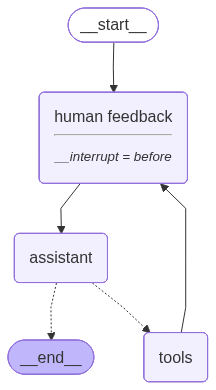

In [24]:
### System Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

## Human feedback  Node 
def human_feedback(state:MessagesState):
    pass

## Assistant Node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Graph
builder = StateGraph(MessagesState)

## Define nodes
builder.add_node("human feedback", human_feedback)
builder.add_node("tools", ToolNode(tools))
builder.add_node("assistant", assistant)

## define the edges
builder.add_edge(START, "human feedback")
builder.add_edge("human feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "human feedback")

memory = MemorySaver()

graph = builder.compile(
    interrupt_before=["human feedback"],
    checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png())) 

In [26]:
## Input 
initial_input = {"messages":"multiply 2 and 3"}

## Thread
thread = {"configurable":{"thread_id":"5"}}

## Run the graph until the interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

## User input 
user_input = input("Tell me how you want to update the state:")
graph.update_state(thread, {"messages":user_input}, as_node="human feedback")

## Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================ Human Message =================================

multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (bkdzn1nym)
 Call ID: bkdzn1nym
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90
